In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from collections import OrderedDict

**Data Loading**

In [44]:
#Load Dataset
df = pd.read_csv("/content/CarPrice_Assignment.csv")
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [45]:
regression_df = df.select_dtypes([int, float]).drop(columns=['car_ID', 'symboling'])
regression_df.head(5)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


**Data Splitting**

In [46]:
Y = regression_df['price']
Y_a = np.expand_dims(Y.to_numpy(), 1)
print(Y.head())

0    13495.0
1    16500.0
2    16500.0
3    13950.0
4    17450.0
Name: price, dtype: float64


In [47]:
threshold = 0.6
correlations = regression_df.corr()['price']
correlations.sort_values(ascending=False)

,price
price,1.000000
enginesize,0.874145
curbweight,0.835305
horsepower,0.808139
carwidth,0.759325
carlength,0.682920
wheelbase,0.577816
boreratio,0.553173
carheight,0.119336
stroke,0.079443


In [48]:
threshold = 0.6
correlations = regression_df.corr()['price']
corr_mask = np.abs(correlations) >= threshold
X = regression_df.loc[:, corr_mask].drop(columns='price')
X_a = X.to_numpy()
X.head()

,carlength,carwidth,curbweight,enginesize,horsepower,citympg,highwaympg
0,168.8,64.1,2548,130,111,21,27
1,168.8,64.1,2548,130,111,21,27
2,171.2,65.5,2823,152,154,19,26
3,176.6,66.2,2337,109,102,24,30
4,176.6,66.4,2824,136,115,18,22


In [49]:
train_frac = 0.7
seed = 100
X_train, X_test, Y_train, Y_test = train_test_split(X_a, Y_a, train_size=0.7, shuffle=True, random_state=seed)
print(len(Y_train), len(Y_test))

143 62


**Feature Selection**

In [50]:
def plot_dataset(X, Y, feature_names):
    n_features = X.shape[1]
    fig, axes = plt.subplots(1, n_features, figsize=(20, 5))
    fig.suptitle('Features vs. Price')

    for i in range(n_features):
        axes[i].scatter(X[:, i], Y)
        axes[i].set_xlabel(feature_names[i])
        axes[i].set_ylabel('Price')

    plt.tight_layout()
    plt.show()

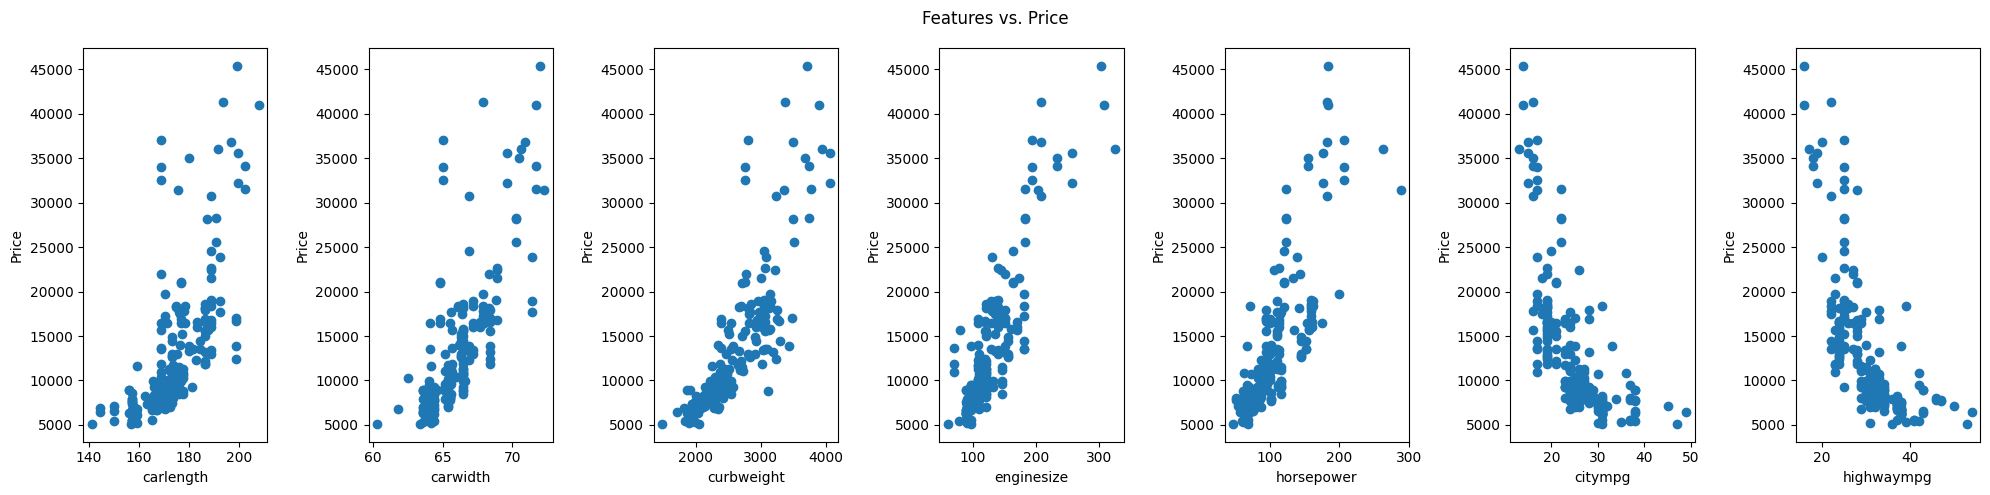

In [51]:
plot_dataset(X_a, Y_a, X.columns)

In [52]:
def feature_map(x):
    # split into positive- and negative-correlated inputs
    x_pos = x[:, :5]
    x_neg = x[:, 5:]
    # define basis by applying the above mentioned non-linear functions
    phi = np.concatenate([x_pos, x_pos**2, 1/x_neg, 1/x_neg**2], axis=1)
    return phi

In [53]:
Phi_train = feature_map(X_train)
Phi_test = feature_map(X_test)
M = Phi_train.shape[1] + 1  # number of features plus intercept term
Phi_train.shape

(143, 14)

**Data Normalization**

In [54]:
print(f'mean: {np.mean(Phi_train, axis=0)}\nvariance: {np.var(Phi_train, axis=0)}')

mean: [1.73416783e+02 6.58398601e+01 2.53951049e+03 1.24958042e+02
 1.02552448e+02 3.02309835e+04 4.33975559e+03 6.74368330e+06
 1.72816434e+04 1.20838671e+04 4.21306020e-02 3.40631179e-02
 1.89639360e-03 1.22074648e-03]
variance: [1.57602795e+02 4.86841117e+00 2.94569774e+05 1.66713111e+03
 1.56686263e+03 1.92768338e+07 8.68445418e+04 8.95579677e+12
 1.81637709e+08 1.22038485e+08 1.21405979e-04 6.04504775e-05
 1.01377475e-06 3.30886645e-07]


In [55]:
class transformation:
    def __init__(self, min_, max_):
        self.min = min_
        self.max = max_
    def feature_transform(self, x):
        # normalize features
        x_new = (x - self.min)/(self.max - self.min)
        # convert features into tensors
        x_new = torch.tensor(x_new, dtype=torch.float32)
        # add intercept term
        x_new = torch.cat((torch.ones(x_new.shape[0], 1), x_new), dim=1)
        return x_new

    def target_transform(self, y):
        return torch.tensor(y, dtype=torch.float32)

In [56]:
# initialize transformation
train_min = Phi_train.min(axis=0)
train_max = Phi_train.max(axis=0)
normalization = transformation(train_min, train_max)
# apply it over dataset
Phi_train_norm = normalization.feature_transform(Phi_train)
Phi_test_norm = normalization.feature_transform(Phi_test)
Y_train_norm = normalization.target_transform(Y_train)
Y_test_norm = normalization.target_transform(Y_test)

In [57]:
print(f'mean: {torch.mean(Phi_train_norm, dim=0)}\nvariance: {torch.var(Phi_train_norm, dim=0)}')
print(f'min: {torch.min(Phi_train_norm, dim=0)[0]}\nmax: {torch.max(Phi_train_norm, dim=0)[0]}')

mean: tensor([1.0000, 0.5255, 0.4617, 0.4079, 0.2414, 0.2273, 0.4883, 0.4422, 0.3163,
        0.1322, 0.1213, 0.3844, 0.3857, 0.2690, 0.2816])
variance: tensor([0.0000, 0.0420, 0.0340, 0.0446, 0.0239, 0.0274, 0.0434, 0.0345, 0.0440,
        0.0174, 0.0189, 0.0383, 0.0375, 0.0337, 0.0343])
min: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
max: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [58]:
print(f'mean: {torch.mean(Phi_test_norm, dim=0)}\nvariance: {torch.var(Phi_test_norm, dim=0)}')
print(f'min: {torch.min(Phi_test_norm, dim=0)[0]}\nmax: {torch.max(Phi_test_norm, dim=0)[0]}')

mean: tensor([1.0000, 0.5595, 0.4804, 0.4285, 0.2657, 0.2489, 0.5217, 0.4602, 0.3295,
        0.1499, 0.1341, 0.3965, 0.3960, 0.2783, 0.2920])
variance: tensor([0.0000, 0.0361, 0.0274, 0.0322, 0.0265, 0.0267, 0.0380, 0.0281, 0.0312,
        0.0241, 0.0149, 0.0363, 0.0402, 0.0330, 0.0426])
min: tensor([1.0000, 0.0569, 0.1833, 0.1284, 0.0679, 0.0167, 0.0473, 0.1698, 0.0764,
        0.0246, 0.0050, 0.1045, 0.0684, 0.0502, 0.0352])
max: tensor([1.0000, 1.0894, 0.9750, 0.9356, 0.9321, 0.6625, 1.1069, 0.9728, 0.9076,
        0.8887, 0.5028, 0.9028, 1.0912, 0.8518, 1.1431])


**Dataset and Dataloder**

In [59]:
class CarPricesDataset(Dataset):
    def __init__(self, features, target, transform=None):
        self.features = features
        self.target = target
        self.transform = transform
    def __len__(self):
            return len(self.target)
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.target[idx]

        # catch cases with no slice index
        if type(idx) == int:
            x = x.reshape(1, -1)
            y = y.reshape(1, -1)

        # transform input
        if self.transform:
            x = self.transform.feature_transform(x)
            y = self.transform.target_transform(y)

        return x, y

In [60]:
# initialize training and test sets from unormalized data
trainset = CarPricesDataset(Phi_train, Y_train, transform=normalization)
testset = CarPricesDataset(Phi_test, Y_test, transform=normalization)

In [61]:
batch_size = 16
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
x_batch, y_batch = next(iter(train_loader))
print(len(x_batch), x_batch.shape, len(y_batch), y_batch.shape)

16 torch.Size([16, 1, 15]) 16 torch.Size([16, 1, 1])


**Model, loss and optimizer**

In [62]:
# model
model = nn.Linear(M, 1, bias=False)

In [63]:
init_parameters = next(model.parameters())
print(init_parameters, len(init_parameters[0]))

Parameter containing:
tensor([[ 0.1526,  0.2052,  0.0907, -0.0411,  0.1908, -0.1189, -0.0056, -0.2393,
         -0.0123, -0.0035,  0.0461, -0.1220, -0.0104,  0.0331, -0.1224]],
       requires_grad=True) 15


In [64]:
# loss function
loss_func = nn.MSELoss()

In [65]:
# optimizer
alpha = 1e-2  # learning rate
optimizer = optim.SGD(model.parameters(), lr=alpha)

**Training the Model**

In [66]:
def train_model(epochs, dataloader, model, loss_func, optimizer, testset, display_freq=100):

    # use for evaluating the model during training
    x_test, y_test = testset[:]

    # store training history into dictionary
    history_dic = {'train': torch.zeros(epochs),
                   'test': torch.zeros(epochs),
                   'weights': torch.zeros([epochs, 1, M])}

    # training loop
    for epoch in range(epochs):
        model.train()  # activates training mode

        for x, y in dataloader:

            optimizer.zero_grad() # restarts gradient for each batch so not to accumulate
            y_pred = model(x) # predicted value
            loss_train = loss_func(y_pred, y)
            loss_train.backward() # computes gradient
            optimizer.step() # updates parameters

        # evaluate trained model on test data
        model.eval()  # activates evaluation mode
        y_test_pred = model(x_test)
        loss_test = loss_func(y_test_pred, y_test)

        # store loss for train and test data and parameters
        history_dic['train'][epoch] = loss_train.item()
        history_dic['test'][epoch] = loss_test.item()
        history_dic['weights'][epoch] = next(model.parameters()).data

        # display partial loss every display_freq epochs
        if epoch%display_freq==0:
            print(f'epoch {epoch}: Training loss {loss_train.item()}, Test loss {loss_test.item()}')

    # best epoch choosen from minimum of test error
    best_epoch = torch.argmin(history_dic['test'])
    optimal_weights = history_dic['weights'][best_epoch]

    print(f'\nBest epoch = {best_epoch}')
    print(f'Training loss = {history_dic["train"][best_epoch]}')
    print(f'Lowest Test loss = {history_dic["test"][best_epoch]}')

    return history_dic, optimal_weights

In [67]:
# parameters
alpha = 1e-2  # learning rate
epochs = 3000

# model
model = nn.Linear(M, 1, bias=False)

# loss function
loss_func = nn.MSELoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=alpha)

history_dic, optimal_weights = train_model(epochs,
                                           train_loader,
                                           model,
                                           loss_func,
                                           optimizer,
                                           testset,
                                           display_freq=100)

epoch 0: Training loss 165239616.0, Test loss 106735904.0
epoch 100: Training loss 3497095.5, Test loss 16295276.0
epoch 200: Training loss 9081662.0, Test loss 15024337.0
epoch 300: Training loss 7202593.0, Test loss 14463807.0
epoch 400: Training loss 4386137.5, Test loss 14113051.0
epoch 500: Training loss 16531523.0, Test loss 13890123.0
epoch 600: Training loss 8905818.0, Test loss 13749372.0
epoch 700: Training loss 3455836.0, Test loss 13649498.0
epoch 800: Training loss 6279259.5, Test loss 13602985.0
epoch 900: Training loss 6322402.5, Test loss 13541046.0
epoch 1000: Training loss 10554086.0, Test loss 13505663.0
epoch 1100: Training loss 8364464.0, Test loss 13495282.0
epoch 1200: Training loss 6578585.0, Test loss 13476324.0
epoch 1300: Training loss 6399389.0, Test loss 13450277.0
epoch 1400: Training loss 16781840.0, Test loss 13438643.0
epoch 1500: Training loss 7757133.0, Test loss 13434830.0
epoch 1600: Training loss 6037743.0, Test loss 13434233.0
epoch 1700: Training

**History Plots**

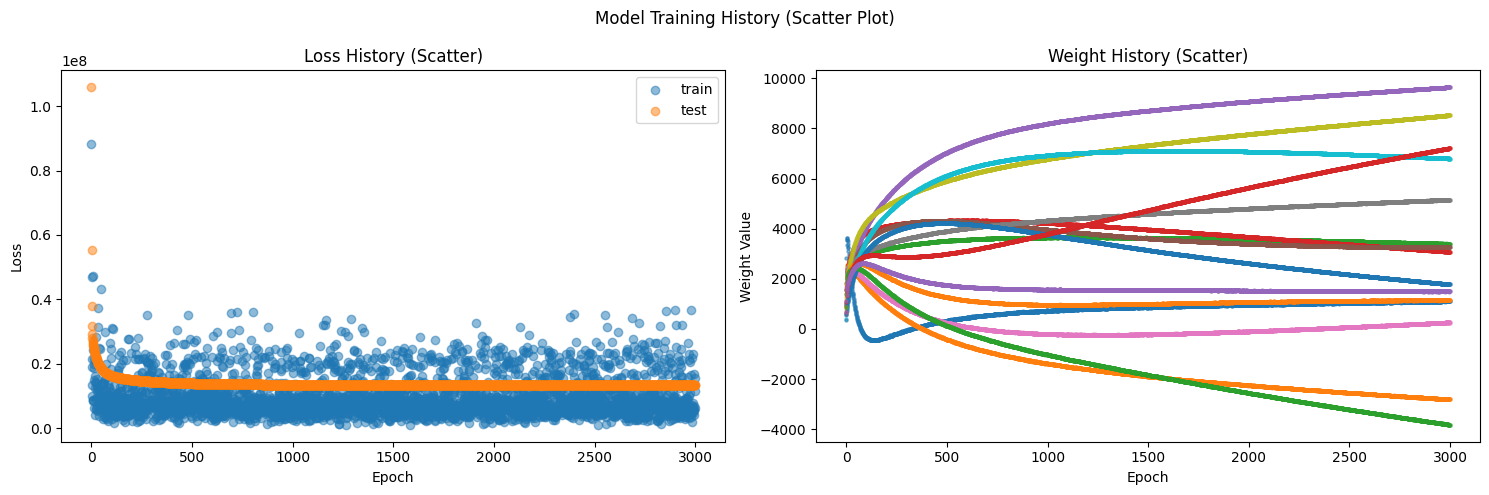

In [42]:
def plot_history_scatter(history_dic):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Model Training History (Scatter Plot)')

    # plot loss as scatter
    ax0.scatter(range(len(history_dic['train'])), history_dic['train'], label='train', alpha=0.5)
    ax0.scatter(range(len(history_dic['test'])), history_dic['test'], label='test', alpha=0.5)
    ax0.set_xlabel('Epoch')
    ax0.set_ylabel('Loss')
    ax0.set_title('Loss History (Scatter)')
    ax0.legend()

    # plot weights as scatter (each weight as a separate series)
    for i in range(history_dic['weights'].shape[2]):
        ax1.scatter(range(history_dic['weights'].shape[0]), history_dic['weights'][:, 0, i].squeeze(), label=f'Weight {i+1}', alpha=0.5, s=5) # Use a small marker size for clarity
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Weight Value')
    ax1.set_title('Weight History (Scatter)')
    # ax1.legend() # uncomment if you want a legend for each weight, might be too cluttered

    plt.tight_layout()
    plt.show()

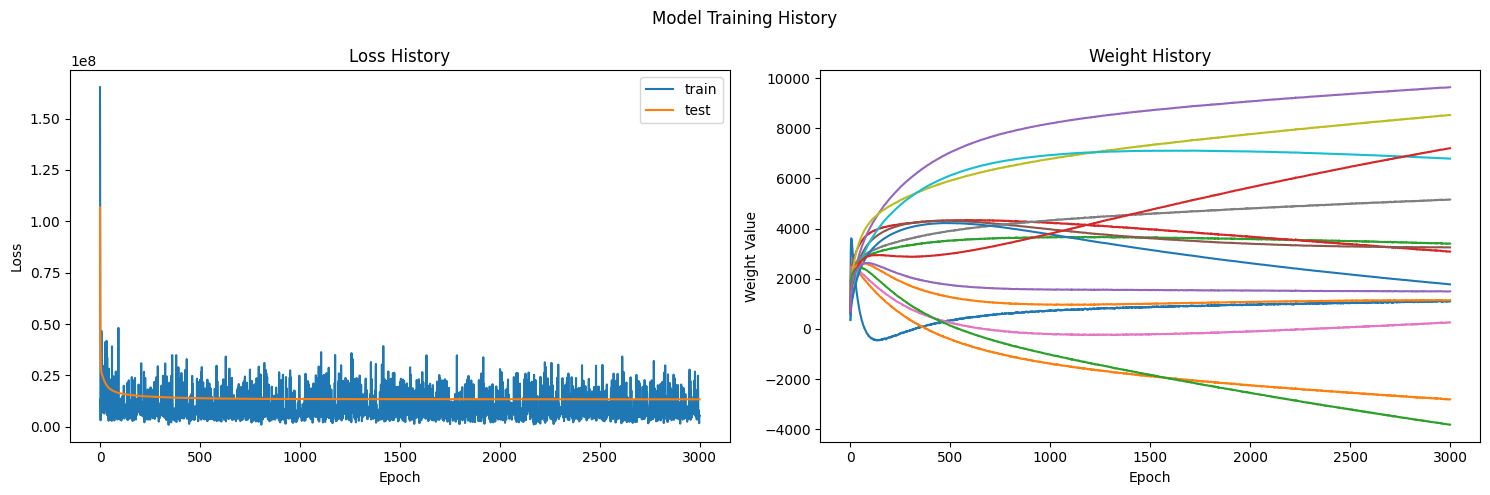

In [68]:
plot_history(history_dic)

**Saving the Model**

In [69]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ 1103.7111, -2812.7881,  3399.0461,  3079.6802,  9636.6973,  3249.5469,
                         256.8134,  5155.8921,  8527.6650,  6788.6475,  1774.3866,  1141.4066,
                       -3821.6919,  7204.8604,  1495.4180]]))])

In [70]:
best_state = OrderedDict({'weight': optimal_weights})
best_state

OrderedDict([('weight',
              tensor([[ 1112.4102, -2777.0811,  3418.8943,  3118.3694,  9617.6523,  3257.1377,
                         246.7231,  5148.7886,  8499.5664,  6811.6025,  1816.3291,  1150.3853,
                       -3754.5901,  7140.8726,  1502.8151]]))])

In [71]:
min_max ={'min': normalization.min, 'max': normalization.max}

In [72]:
model_path = './model_e3000.pth'
torch.save({'state': best_state, 'transformation_parameters': min_max}, model_path)

In [73]:
model = nn.Linear(M, 1, bias=False)
print(model.state_dict())

state = torch.load(model_path, weights_only=False)['state']
min_max = torch.load(model_path, weights_only=False)['transformation_parameters']

model.load_state_dict(state)
print(model.state_dict())

OrderedDict([('weight', tensor([[ 0.1876,  0.0011,  0.0802, -0.2525, -0.2013,  0.0339, -0.0317, -0.1664,
          0.0826, -0.0852, -0.2257,  0.1701,  0.0826, -0.1151,  0.1709]]))])
OrderedDict([('weight', tensor([[ 1112.4102, -2777.0811,  3418.8943,  3118.3694,  9617.6523,  3257.1377,
           246.7231,  5148.7886,  8499.5664,  6811.6025,  1816.3291,  1150.3853,
         -3754.5901,  7140.8726,  1502.8151]]))])


**Evaluate the model on test set**

In [74]:
def predict_price(x, min_, max_):
    min_max_scaling  = transformation(min_, max_)
    phi = feature_map(x)
    phi_norm = min_max_scaling.feature_transform(phi)
    y_pred = model(phi_norm).data
    return y_pred

In [75]:
def plot_with_predicted(X, Y, Y_pred, feature_names):
    n_features = X.shape[1]
    fig, axes = plt.subplots(1, n_features, figsize=(20, 5))
    fig.suptitle('Features vs. Price with Predictions')

    for i in range(n_features):
        axes[i].scatter(X[:, i], Y, label='Actual')
        axes[i].scatter(X[:, i], Y_pred, label='Predicted')
        axes[i].set_xlabel(feature_names[i])
        axes[i].set_ylabel('Price')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

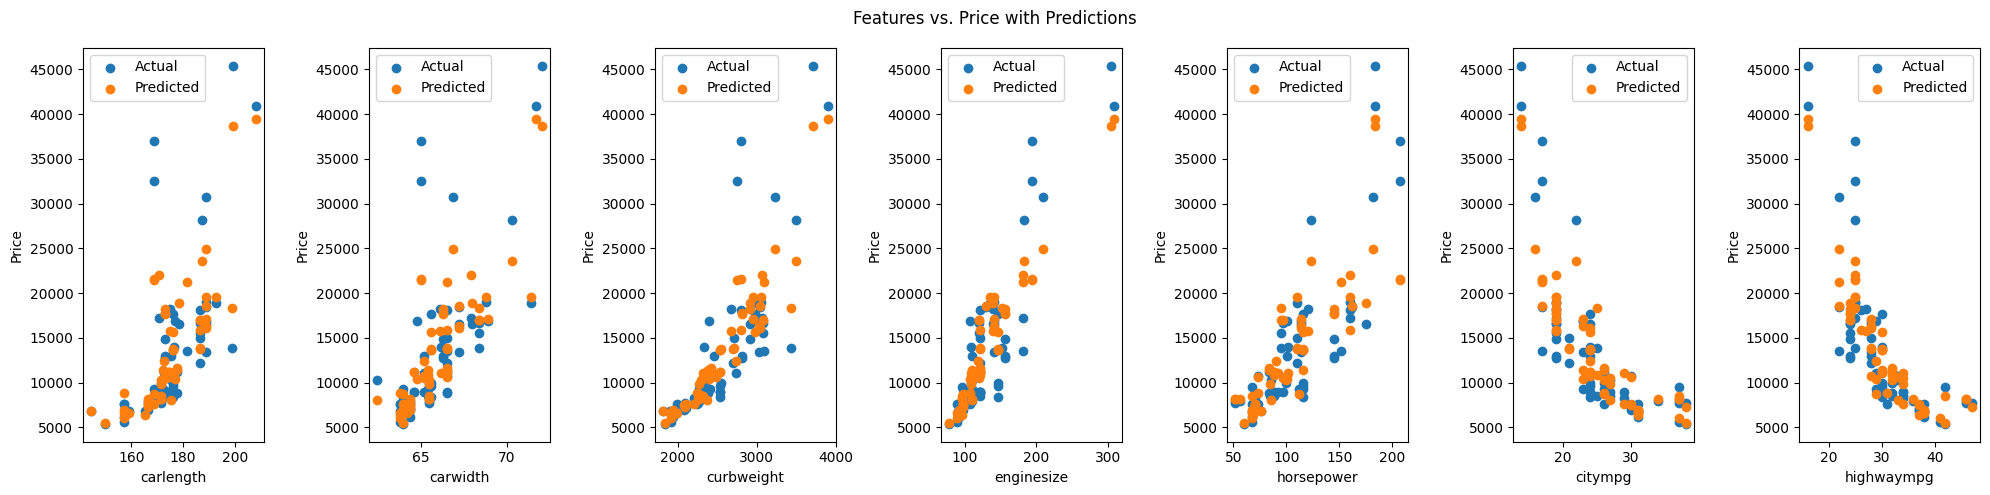

In [76]:
Y_test_pred = predict_price(X_test, min_max['min'], min_max['max'])
plot_with_predicted(X_test, Y_test, Y_test_pred, X.columns)

In [77]:
Y_test_pred = predict_price(X_test, min_max['min'], min_max['max'])
R2_test = r2_score(torch.tensor(Y_test), Y_test_pred)
print(R2_test)

0.8093521582063194


In [78]:
Y_train_pred = predict_price(X_train, min_max['min'], min_max['max'])
R2_train = r2_score(torch.tensor(Y_train), Y_train_pred)
print(R2_train)

0.8404704579965444
